# PART 1. Data-pre processing

<strong> Step #0 - Start the program by importing the libraries </strong>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

<strong>Step #1 - Reading the Data </strong> 

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('https://raw.githubusercontent.com/zalven/covid-19-prediction-2021/main/covid_prediction_data/philippines_covid_cases.csv')




# Select features (columns) to be involved intro training and predictions


predict_value = 'new_cases'       # Legend that we want to predict 


# Legends that support the legend we want to predict
cols = [
    'total_cases',
    'total_cases_per_million',
    'reproduction_rate',
    'total_tests',
    'total_deaths',
    'stringency_index',
    'people_fully_vaccinated',
    'people_vaccinated'
] 



n_future = 60                     # Number of days we want top predict into the future
n_past =  30                      # Number of past days we want to use to predict the future
n_starting_date = '2020-01-30'

# Generate columns 
cols.insert(0, predict_value)  

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['date'])
datelist_train = [dt.datetime.strptime(date,'%m/%d/%Y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (499, 51)
All timestamps == 499
Featured selected: ['new_cases', 'total_cases', 'total_cases_per_million', 'reproduction_rate', 'total_tests', 'total_deaths', 'stringency_index', 'people_fully_vaccinated', 'people_vaccinated']


In [3]:
dataset_train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,PHL,Asia,Philippines,1/30/2020,1,1,0.0,0,0,0.0,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.00
1,PHL,Asia,Philippines,1/31/2020,1,0,0.0,0,0,0.0,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,2.83
2,PHL,Asia,Philippines,2/1/2020,1,0,0.0,0,0,0.0,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.00
3,PHL,Asia,Philippines,2/2/2020,2,1,0.0,1,1,0.0,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.00
4,PHL,Asia,Philippines,2/3/2020,2,0,0.0,1,0,0.0,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.00


In [4]:
dataset_train.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
494,PHL,Asia,Philippines,6/7/2021,1276004,6526,6529.000,21969,71,143.286,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.0
495,PHL,Asia,Philippines,6/8/2021,1280773,4769,6472.286,22064,95,150.286,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.0
496,PHL,Asia,Philippines,6/9/2021,1286217,5444,6500.143,22190,126,147.429,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.0
497,PHL,Asia,Philippines,6/10/2021,1293687,7470,6541.143,22312,122,136.429,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.0
498,PHL,Asia,Philippines,6/11/2021,1300349,6662,6430.286,22507,195,138.571,...,7599.188,370.437,7.07,7.8,40.8,78.463,1,71.23,0.718,0.0


<strong>Step #2 - Data pre processing </strong> 

In [5]:

dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (499, 9).


array([[1.0000000e+00, 1.0000000e+00, 9.0000000e-03, ..., 1.1110000e+01,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 9.0000000e-03, ..., 1.9440000e+01,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 9.0000000e-03, ..., 1.9440000e+01,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [5.4440000e+03, 1.2862170e+06, 1.1737582e+04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.4700000e+03, 1.2936870e+06, 1.1805751e+04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.6620000e+03, 1.3003490e+06, 1.1866546e+04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [6]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.31696338e-01],
       [-9.32054145e-01],
       [-9.3

In [7]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (410, 30, 8).
y_train shape == (410, 1).


# PART 2. Create a model. Training

<strong> Step #3. Building the LSTM based Neural Network </strong>

In [8]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [9]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<strong> Step #4. Start training </strong> 

In [10]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
2/2 [==============================] - 42s 3s/step - loss: 0.3300 - val_loss: 3.3043

Epoch 00001: val_loss improved from inf to 3.30431, saving model to weights.h5
Epoch 2/30
2/2 [==============================] - 0s 56ms/step - loss: 0.2111 - val_loss: 3.4266

Epoch 00002: val_loss did not improve from 3.30431
Epoch 3/30
2/2 [==============================] - 0s 69ms/step - loss: 0.2101 - val_loss: 2.5269

Epoch 00003: val_loss improved from 3.30431 to 2.52691, saving model to weights.h5
Epoch 4/30
2/2 [==============================] - 0s 64ms/step - loss: 0.1694 - val_loss: 1.6059

Epoch 00004: val_loss improved from 2.52691 to 1.60589, saving model to weights.h5
Epoch 5/30
2/2 [==============================] - 0s 55ms/step - loss: 0.1479 - val_loss: 3.2299

Epoch 00005: val_loss did not improve from 1.60589
Epoch 6/30
2/2 [==============================] - 0s 101ms/step - loss: 0.1194 - val_loss: 3.4981

Epoch 00006: val_loss did not improve from 1.60589
Epoch 7/30
2/2

# PART 3. Make future predictions++

In [11]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<strong> Step #5. Make predictions for future dates </strong>

In [12]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [13]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['new_cases']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['new_cases']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)


,new_cases
2020-05-28,825.284424
2020-05-29,827.977783
2020-05-30,832.279663


In [14]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
PREDICTIONS_FUTURE

dataset_train.set_index( pd.date_range(start=n_starting_date, periods=499) , inplace=True)
dataset_train.tail()

,new_cases,total_cases,total_cases_per_million,reproduction_rate,total_tests,total_deaths,stringency_index,people_fully_vaccinated,people_vaccinated
2021-06-07,6526.0,1276004.0,11644.382,1.04,12978141.0,21969.0,71.76,1604260.0,4491948.0
2021-06-08,4769.0,1280773.0,11687.902,1.03,13030867.0,22064.0,0.00,1681722.0,4632826.0
2021-06-09,5444.0,1286217.0,11737.582,1.03,13079519.0,22190.0,0.00,0.0,0.0
2021-06-10,7470.0,1293687.0,11805.751,0.00,0.0,22312.0,0.00,0.0,0.0
2021-06-11,6662.0,1300349.0,11866.546,0.00,0.0,22507.0,0.00,0.0,0.0


In [15]:
 PREDICTIONS_FUTURE.tail()

,new_cases
2021-08-05,5885.314941
2021-08-06,5864.174805
2021-08-07,5855.287598
2021-08-08,5866.711426
2021-08-09,5877.104004


<strong> Step #6. Visualize the Predictions </strong>

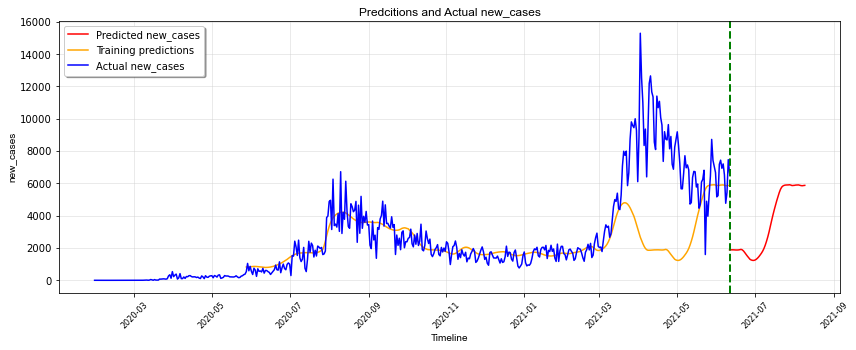

In [16]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = n_starting_date
, PREDICTIONS_FUTURE[predict_value]
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='r', label='Predicted '+predict_value)
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][predict_value], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][predict_value], color='b', label='Actual '+predict_value)

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual '+predict_value , family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel(predict_value, family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

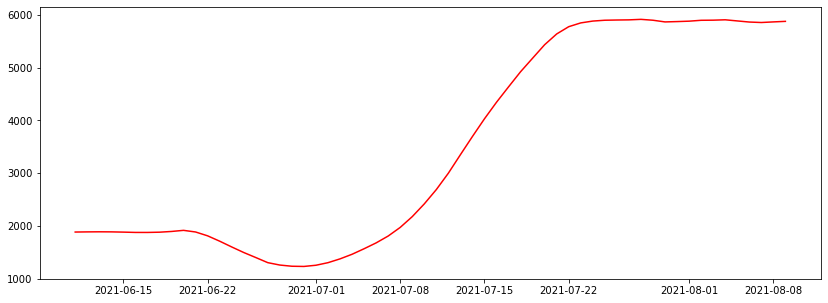

In [17]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='r', label='Predicted '+predict_value)
plt.show()